In [147]:
import pandas as pd # packages for reading in data
import numpy as np
import matplotlib.pyplot as plt  # packages for displaying data
from matplotlib.patches import Rectangle
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm
from statsmodels.tsa.stattools import acf, pacf #packages for statistics
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import r2_score,  mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from pandas.plotting import autocorrelation_plot


from pmdarima import auto_arima

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

sns.set_style("darkgrid") # setting style

In [94]:
df = pd.read_csv("../data/chennai_complete.csv",index_col='date',parse_dates=True, # setting the index to datetime
                 usecols=['date','chembarambakkam_water','chembarambakkam_rain']) # selecting columns

In [95]:
df = df.resample("M").mean()

---

Stationarity is an important assumption when working with time-series data.
Later on in the project, the model will not work properly unless the time data is stationary.

One way to determine stationary is to implement the Augmented Dickey-Fuller test.

A **small $p$-value** (**<.05**) in the test would give us evidence and tell us to reject the null hypothesis, meaning we accept that **our time series is indeed stationary**

In [131]:
adfuller(df["chembarambakkam_water"])

(-3.9833081000530304,
 0.0015004816743128208,
 2,
 189,
 {'1%': -3.4654311561944873,
  '5%': -2.8769570530458792,
  '10%': -2.574988319755886},
 2534.8271277324893)

**Interpretation**: We are 95% confident that our data is stationary.

#### Plotting ACF, PACF

Before we model, we want to see if there are any trends and lags that can feed into the AR and MA parts of our ARIMA model. We are doing this plotting both the auto-correlation function and partial auto-correlation function.

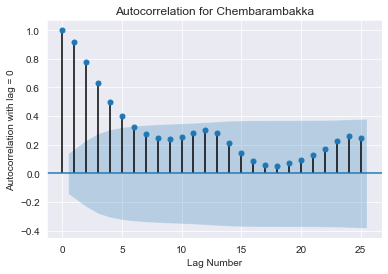

In [97]:
plot_acf(df['chembarambakkam_water'], lags =25)
plt.xlabel("Lag Number")
plt.ylabel("Autocorrelation with lag = 0")
plt.title("Autocorrelation for Chembarambakka");

**Interpretation**: The plot seems to show a trend downward.

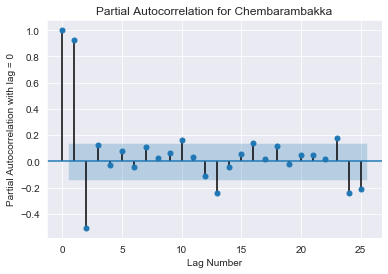

In [98]:
plot_pacf(df['chembarambakkam_water'], lags = 25)
plt.xlabel("Lag Number")
plt.ylabel("Partial Autocorrelation with lag = 0")
plt.title("Partial Autocorrelation for Chembarambakka");

**Interpretation**: The Partial-autocorrelation Function plot is showing here that there are significant lags at 1, 2, 10, 13, 23, 24, 25 months. We can see this based on the point being outside of the 95% confidence interval represented by the blue. 

## Modeling
---

### Baseline


Before we model, we are going to establish a baseline model by which to compare all other results.

In [99]:
df_dumb = df["chembarambakkam_water"]

We are making a data frame and shifting one of the columns and lagging it by one.

In [135]:
values = df_dumb
dataframe = pd.concat([values.shift(1), values], axis=1) #lagging the data a mont
dataframe.columns = ['t', 't+1']
print(dataframe.head(5))

              t  t+1
date                
2004-01-31  NaN  0.0
2004-02-29  0.0  0.0
2004-03-31  0.0  0.0
2004-04-30  0.0  0.0
2004-05-31  0.0  0.0


In [136]:
X = dataframe['t+1']
y= dataframe['t']

In [137]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .34, shuffle = False)

In [138]:
test_score = mean_squared_error(y_test, X_test)
print(f'Test MSE: {test_score}')

Test MSE: 131725.53848875794


**Interpretation**: This Baseline Model is the simplest possible model, lagging the data for one month and predicting the next month. This model has a MSE of 131725.538 which we will use as a benchmark for future models.

### ARIMA

---

#### Model Pre-processing 

We are now going to be modeling our time-series data with an ARIMA Model.

An ARIMA model has three components.
1.  AR: Autoregressive. This means we regress the target variable on its own past values. In our case lagging a month or months of data.     
     
       

2.  I: Integrated. This shows we are differencing the data.     
 
  


3. MA: Moving Average. This is a model that forecasts Y using our model’s past errors to correct our model's forecast.

In [104]:
y = df["chembarambakkam_water"]

y_train_ar, y_test_ar = train_test_split(y, test_size = .34, shuffle = False)

Now that we have split the data, we can run the Auto ARIMA.

We are running an auto arima to calculate the best order for  the model.

In [139]:
fitted_arima = auto_arima(
    y_train, # data
    start_p = 0,
    start_q = 0,
    max_p = 2,
    max_q = 2,
    d = 0, 
    stationary = True, # in this case our data is  stationary
    seasonal=True, 
    solver='lbfgs', 
    trace=True,
    error_action='ignore',  
    suppress_warnings=True  
)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2068.506, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1836.633, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=1938.102, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2228.823, Time=0.00 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1804.365, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1805.127, Time=0.04 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=1807.127, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1812.970, Time=0.02 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.341 seconds


---

Now we are fitting our ARIMA model on the training data and generating rolling forecasts for each point in the test data. We are iterating through each observation and storing the observation.

In [113]:
X = df.chembarambakkam_water.values # getting the values

size = int(len(X) * 0.66) 

train, test = X[0:size], X[size:len(X)] 
    
history =  list(train) # making the train into a list 

predictions = list() #setting up a list for the predictions

for t in range(len(test)): #using the len of the testset to iterate through testing data
    
    model = ARIMA(history, order=(1,0,1)) # Instantiating model
    
    model_fit = model.fit(disp=0) #fitting model and stopping display data
    
    output = model_fit.forecast() #forcasting 
    
    yhat = output[0] #feeding the predictions into the variable
    
    predictions.append(yhat) #appending the predictions to the list we create
    
    obs = test[t] 
    
    history.append(obs)
    
    print('predicted=%f, expected=%f' % (yhat, obs))
    
error = mean_squared_error(test, predictions)

print(f'Test MSE: {error}') #printing the rmse


predicted=1167.625045, expected=990.645161
predicted=957.780505, expected=741.096774
predicted=717.263427, expected=615.266667
predicted=662.514095, expected=940.548387
predicted=1139.149992, expected=1221.833333
predicted=1288.307835, expected=1081.032258
predicted=1018.788663, expected=931.709677
predicted=947.920225, expected=690.857143
predicted=649.663759, expected=842.290323
predicted=1008.175683, expected=788.133333
predicted=754.382823, expected=694.064516
predicted=749.509669, expected=530.200000
predicted=524.367177, expected=409.354839
predicted=467.237805, expected=246.741935
predicted=267.790410, expected=174.400000
predicted=263.709091, expected=210.032258
predicted=312.830105, expected=1897.000000
predicted=2608.469276, expected=3138.225806
predicted=3154.795855, expected=3028.580645
predicted=2737.807534, expected=3041.793103
predicted=2983.484520, expected=2628.032258
predicted=2272.370098, expected=2223.266667
predicted=2084.700650, expected=2396.064516
predicted=2428

**Interpretation**: Our model got an MSE score of 90,810; this is considerably better than the baseline of 131,725. 

The next steps would be:
 
* to further tune the p, d, q  
* to gather more data  
* to forecast over different periods.  


---

## Model Selection
---

We are selecting the ARIMA model for evaluation.

## Model Evaluation 
---

#### Looking at the Residuals

When we look at the residuals, we are primarily interested in looking at the mean. A mean value close to zero would suggest no bias in the forecast.

In [120]:
print(residuals.describe())

                 0
count   191.000000
mean      1.766270
std     321.704375
min   -1217.091999
25%    -159.814886
50%     -85.614076
75%     107.991400
max    1983.441184


**Interpretation**: Looking at the mean, it suggests that there is a positive bias, and we could improve the model by doing a bias correction.

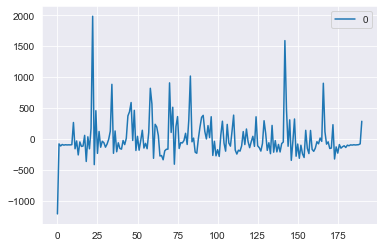

In [150]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot();



**Interpretation**: There seem to be some trends and cycles which indicate we have not captured those elements. In a perfect model, this plot of the residuals would look completely random.

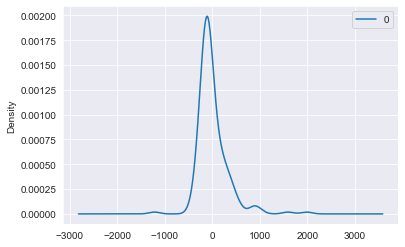

In [151]:
residuals.plot(kind='kde');

**Interpretation**: This density plot seems to be to narrow and the wrong shape to be a Gaussian distribution, indicating that the model's error distribution may not be normally distributed.

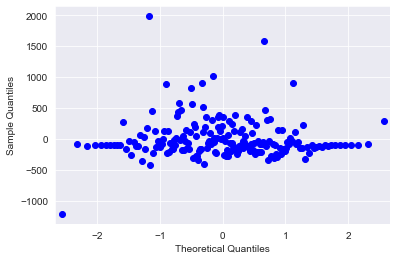

In [149]:
qqplot(residuals);

**Interpretation**:  The outliers seem to have to be having a dramatic effect on our model's residuals. 

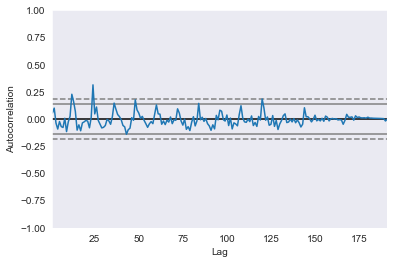

In [155]:
autocorrelation_plot(residuals);

**Interpretation**: There doesn't appear to be any clear autocorrelation trend across the plot. There may be some positive autocorrelation worthy of further investigation at lag 25 that seems significant.

### Visualizing Predictions

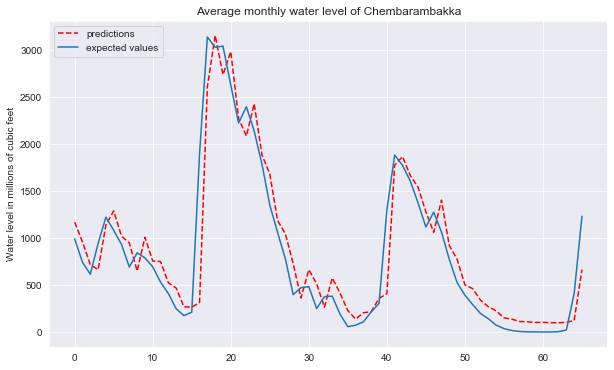

In [161]:
plt.figure(figsize=((10, 6)))
plt.title("Average monthly water level of Chembarambakka")

plt.ylabel("Water level in millions of cubic feet")

plt.plot(predictions, color='red', ls= 'dashed', label= "predictions")
plt.plot(test, label= "expected values")
plt.legend(loc = "upper left");



**Interpretation**:The model follows fairly well with the large shocks and spikes in the data. However, there are points where the model is off. This model may need further tuning of the p,d or q.